In [36]:
! pip install streamlit

  Using cached altair-5.4.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -------------------------- ------------- 5.8/8.7 MB 58.6 MB/s eta 0:00:01
   ----------------------------- ---------- 6.6/8.7 MB 19.2 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 15.1 MB/s eta 0:00:00
Using cached altair-5.4.1-py3-none-any.whl (658 kB)
Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)
Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
Using cached toml-0.10.2-py2.py3


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from datetime import timedelta

pd.set_option('display.max_columns', 40)
# display max rows 75
pd.set_option('display.max_rows', 75)

# fichiers source
Attention aux noms des tables et des variables.
Attention aux noms des fichiers générés

* df_book --> df_book_updated --> df_book_streamlit
* df_stat

In [4]:
df_book = pd.read_parquet('../data_sources_from_python/df_book.parquet')
df_book.to_excel("df_book.xlsx", index=False)
df_book.head(5)

,id,Titre,Auteurs,notes,Date dernière ouverture,page,Série,Langue,total_read_time,total Nbr de pages lues,oeuvre,id long,Auteurs courts,format,First published date,categorie
0,2,Le crime de l'Orient-Express,"Christie, Agatha",0,2023-11-27,349,l'Orient #1,fr,13191,330,"Le crime de l'Orient-Express - Christie, Agatha",00002,Christie Agatha,ebook,1934,fiction/SF
1,3,Let's Get Together,Isaac Asimov,0,2023-11-27,68,N/A,en,388,8,Let's Get Together - Isaac Asimov,00003,Isaac Asimov,ebook,1957,fiction/SF
2,4,La nuit des temps,"Barjavel,René",0,2024-01-08,449,N/A,und,12240,289,"La nuit des temps - Barjavel,René",00004,Barjavel René,ebook,1968,fiction/SF
3,5,"Chasseur, cueilleur, parent: les cultures ance...",Michaeleen Doucleff,0,2024-01-09,675,N/A,fr,18029,418,"Chasseur, cueilleur, parent: les cultures ance...",00005,Michaeleen Doucleff,ebook,2021,non-fiction/parenting
4,11,La faune de l'espace,"Van Vogt,Alfred E",0,2024-01-08,809,N/A,fr,22,2,"La faune de l'espace - Van Vogt,Alfred E",00011,Van Vogt,ebook,1950,fiction/SF


In [5]:
df_stat = pd.read_parquet('../data_sources_from_python/stats_lecture.parquet')
df_stat.to_excel("df_stat.xlsx", index=False)
df_stat.tail(5)

,id_book,page,heure de début,Temps passé sur la page en seconde,total_pages,id_long,Temps de lecture en minute,Temps de lecture en heure,date lecture,Heure de début de lecture,Heure,Heure en décimal,Jour Précédent,Est Consécutif,date de fin de lecture
19027,73,127,2024-11-06 11:52:13,21,636,00073,0.350000,0.005833,2024-11-06,11:52:13,11,11.866667,2024-11-05,True,2024-11-06
19028,73,130,2024-11-06 11:52:49,30,636,00073,0.500000,0.008333,2024-11-06,11:52:49,11,11.866667,2024-11-05,True,2024-11-06
19029,73,125,2024-11-06 11:51:30,20,636,00073,0.333333,0.005556,2024-11-06,11:51:30,11,11.850000,2024-11-05,True,2024-11-06
19030,73,120,2024-11-06 11:50:06,31,636,00073,0.516667,0.008611,2024-11-06,11:50:06,11,11.833333,2024-11-05,True,2024-11-06
19031,73,133,2024-11-06 13:20:05,69,636,00073,1.150000,0.019167,2024-11-06,13:20:05,13,13.333333,2024-11-05,True,2024-11-06


In [6]:
print(df_stat.columns)

Index(['id_book', 'page', 'heure de début',
       'Temps passé sur la page en seconde', 'total_pages', 'id_long',
       'Temps de lecture en minute', 'Temps de lecture en heure',
       'date lecture', 'Heure de début de lecture', 'Heure',
       'Heure en décimal', 'Jour Précédent', 'Est Consécutif',
       'date de fin de lecture'],
      dtype='object')


# visuel 1 : table avec la liste des livres lus dans l'année. --> DONE
## step 1 : easy
* trié du plus récent au plus ancien 
* uniquement les livres lus en entier

## step 2 : 
* Récupérer le nombre de jour de lecture pour chaque livre 
* calculer le nombre de pages lues par jour de lecture
* calculer le nombre d'heures de lecture par jour de lecture
* calculer la vitesse de lecture : page /min

In [8]:
# Ignorer les avertissements
warnings.filterwarnings('ignore')

# Assurez-vous que la colonne "date lecture" est bien de type datetime
df_stat['date lecture'] = pd.to_datetime(df_stat['date lecture'])

# Grouper df_stat par 'id_book' et calculer les valeurs souhaitées
df_stat_grouped = df_stat.groupby('id_book').agg({
    'Temps passé sur la page en seconde': 'sum',
    'date lecture': ['nunique', 'min', 'max']
}).reset_index()

# Aplatir les colonnes multi-niveaux résultantes après l'aggrégation
df_stat_grouped.columns = ['id', 'total_temps_sur_page_seconde', 'nb_dates_lecture_distinctes', 'start_date', 'end_date']

# Calculer la durée de l'intervalle de lecture
df_stat_grouped['intervalle_lecture_en_jour'] = 1 +(df_stat_grouped['end_date'] - df_stat_grouped['start_date']).dt.days

# Fusionner les résultats avec df_book
df_book_updated = df_book.merge(df_stat_grouped, how='left', on='id')

# Remplacer les valeurs NaN pour les colonnes nouvellement calculées, si nécessaire
df_book_updated['total_temps_sur_page_seconde'].fillna(0, inplace=True)
df_book_updated['nb_dates_lecture_distinctes'].fillna(0, inplace=True)
df_book_updated['intervalle_lecture_en_jour'].fillna(0, inplace=True)

# nombre de page lue par jour de lecture (total Nbr de pages lues / nb_dates_lecture_distinctes), arrondi à 2 chiffres après la virgule

df_book_updated['nb_pages_lues_par_jour_de_lecture'] = (df_book_updated['total Nbr de pages lues'] / df_book_updated['nb_dates_lecture_distinctes']).round(1)

# heure de lecure par jour de lecture
df_book_updated['heure_lecture_par_jour_de_lecture'] = (df_book_updated['total_temps_sur_page_seconde'] / df_book_updated['nb_dates_lecture_distinctes'] / 3600).round(2)
df_book_updated['minutes_lecture_par_jour_de_lecture'] = (df_book_updated['total_temps_sur_page_seconde'] / df_book_updated['nb_dates_lecture_distinctes'] / 60).round(1)

# Remplacer les valeurs NaN dans la colonne 'heure_lecture_par_jour_de_lecture' par 0
df_book_updated['heure_lecture_par_jour_de_lecture'].fillna(0, inplace=True)

# Convertir les heures de lecture en durée formatée (HH:MM:SS)
df_book_updated['temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)'] = df_book_updated['heure_lecture_par_jour_de_lecture'].apply(
    lambda x: str(timedelta(hours=x))
)

# passer temps_lecture_par_jour_de_lecture_formatee en hh:mm
df_book_updated['temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)'] = df_book_updated['temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)'].str[:4]

df_book_updated["total_temps_de_lecture_(hh:mm:ss)"] = df_book_updated["total_temps_sur_page_seconde"].apply(
    lambda x: str(timedelta(seconds=x))
)

# drop les lignes ou "nb_dates_lecture_distinctes" est égale à 0
df_book_updated = df_book_updated[df_book_updated['nb_dates_lecture_distinctes'] != 0]

# order by "Date dernière ouverture"
df_book_updated = df_book_updated.sort_values(by='Date dernière ouverture', ascending=False)

# ajoute une colonne "pourcent_lu" : "total Nbr de pages lues du livre" / "page"
df_book_updated['pourcent_lu'] = (df_book_updated['total Nbr de pages lues'] / df_book_updated['page'] * 100).round(0)

df_book_updated["temps passé sur le livre en minute"] = (df_book_updated["total_temps_sur_page_seconde"] / 60).round(2)
df_book_updated["temps passé sur le livre en heure"] = (df_book_updated["total_temps_sur_page_seconde"] / 3600).round(2)

# rename colonnes page en page total livre
df_book_updated.rename(columns={
    'page': 'total Nbr de pages du livre',
    "total_temps_sur_page_seconde":"temps passé sur le livre en seconde"

    }, inplace=True)


# diviser la colonne série en 2 : série et numéro de série, en utilisant "#" comme séparateur
df_book_updated[['série', 'numéro_série']] = df_book_updated['Série'].str.split('#', expand=True)

# changer le format de start_date et end_date en yyyy-mm-dd
df_book_updated['start_date'] = df_book_updated['start_date'].dt.strftime('%Y-%m-%d')
df_book_updated['end_date'] = df_book_updated['end_date'].dt.strftime('%Y-%m-%d')

# pourcent lu en pourcentage avec 0 chiffre après la virgule
df_book_updated['pourcent_lu'] = df_book_updated['pourcent_lu'].astype(int)
df_book_updated['intervalle_lecture_en_jour'] = df_book_updated['intervalle_lecture_en_jour'].astype(int)
df_book_updated['nb_dates_lecture_distinctes'] = df_book_updated['nb_dates_lecture_distinctes'].astype(int)

# si pourcent_lu est supérieur à 92, le mettre à 100
df_book_updated.loc[df_book_updated['pourcent_lu'] > 92, 'pourcent_lu'] = 100

# drop colonnes
df_book_updated.drop(columns=[
    'total_read_time', 
    'id long',
    "notes",
    "Série",
    "format"
    ], inplace=True)

df_book_updated["pages lues à la minute"] = df_book_updated["total Nbr de pages lues"] / df_book_updated["temps passé sur le livre en minute"]

# remettre les colonnes dans l'odre : 

ordered_columns = [
    'id', 'Titre', 'Auteurs', 'Auteurs courts', 'Langue', 
    'categorie', 'série', 'numéro_série', 'oeuvre', 'First published date', 
    'Date dernière ouverture', 'total Nbr de pages du livre', 'total Nbr de pages lues',"pages lues à la minute", 
    'pourcent_lu', 'start_date', 'end_date', 'intervalle_lecture_en_jour', 
    'nb_dates_lecture_distinctes', 'nb_pages_lues_par_jour_de_lecture', 
    'temps passé sur le livre en seconde', 'temps passé sur le livre en minute', 
    'temps passé sur le livre en heure', 'heure_lecture_par_jour_de_lecture', 
    'minutes_lecture_par_jour_de_lecture', 'temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)', 
    'total_temps_de_lecture_(hh:mm:ss)'
]

# Réorganiser les colonnes dans le DataFrame
df_book_updated = df_book_updated[ordered_columns]


df_book_updated.to_parquet('df_book_updated.parquet', engine='pyarrow',index=False)
df_book_updated.to_excel('df_book_updated.xlsx', index=False)

# formatage pour STREAMLIT
# redrop des colonnes : id, auteurs, Langue, oeuvre,
df_book_streamlit = df_book_updated.drop(columns=[
    'id',
    'Auteurs',
    'Langue',
    'oeuvre',
    "temps passé sur le livre en seconde",
    "temps passé sur le livre en minute",
    "heure_lecture_par_jour_de_lecture"
    ])


# renaming des colonnes : auteurs courts en Auteurs
df_book_streamlit.rename(columns={
    'Auteurs courts': 'Auteurs',
    "série":"Série",
    "categorie":"Catégorie",
    "numéro_série":"#",
    "First published date":"Année publication",
    "Date dernière ouverture":"Date de lecture",
    "total Nbr de pages du livre":"# pages",
    "total Nbr de pages lues":"# pages lues",
    "pourcent_lu":"% lu",
    "start_date":"Commencé",
    "end_date":"Terminé",
    "intervalle_lecture_en_jour":"Durée lecture (j)",
    "nb_dates_lecture_distinctes":"jours de lecture effectifs (jl)",
    "nb_pages_lues_par_jour_de_lecture":"# pages lues/jl",	
    "total_temps_de_lecture_(hh:mm:ss)": "Temps de lecture total (hh:mm:ss)",
    "minutes_lecture_par_jour_de_lecture":"minutes de lecture/jl",
    "temps_lecture_par_jour_de_lecture_formatee(hh:mm:ss)": "Temps de lecture h:m/jl",
    "Temps de lecture total (hh:mm:ss)": "Temps de lecture total"

    }, inplace=True)


# export en parquet sans la colonne index
df_book_streamlit.to_parquet('df_book_streamlit.parquet', engine='pyarrow',index=False)
# export en excel
df_book_streamlit.to_excel('df_book_streamlit.xlsx', index=False)


In [34]:
print(df_book_streamlit.info())
print(df_book_updated.info())

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 63 to 0
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Titre                              63 non-null     object 
 1   Auteurs                            63 non-null     object 
 2   Catégorie                          63 non-null     object 
 3   Série                              63 non-null     object 
 4   #                                  22 non-null     object 
 5   Année publication                  63 non-null     object 
 6   Date de lecture                    63 non-null     object 
 7   # pages                            63 non-null     int64  
 8   # pages lues                       63 non-null     int64  
 9   % lu                               63 non-null     int64  
 10  Commencé                           63 non-null     object 
 11  Terminé                            63 non-null     object 
 12  D

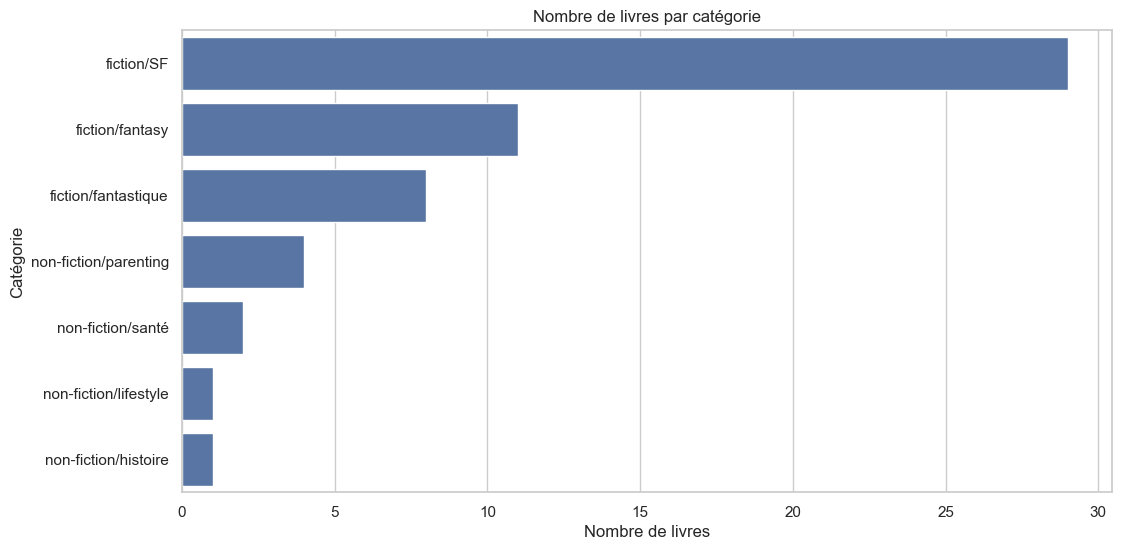

In [ ]:
# plot avec seaborn en bar chhat le nombre de livre par categorie

#TODO 1 couleur par categorie principale "fiction" ou "non-fiction"


sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='Catégorie', data=df_book_streamlit, order=df_book_streamlit['Catégorie'].value_counts().index)
plt.title('Nombre de livres par catégorie')
plt.xlabel('Nombre de livres')
plt.ylabel('Catégorie')
plt.show()

# visuel 2
heatmap heure de lecture et calendrier

# 3 score card
* plus longue lecture : heure de lecture max
* le plus régulier : jour de lecture = intervalle de lecture
* plus rapide : page lues à la minute
* plus addictif : pages lues par jour

## plus longue lecture

In [9]:
# le temps de lecture max
temps_maxi = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]

# prisme livre
titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Titre"].values[0]
auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Auteurs"].values[0]
temps_max_lecture = df_book_streamlit["temps passé sur le livre en heure"].max()


print(f"Livre le plus long à lire : {titre_max_temps_lecture} de {auteur_max_temps_lecture} : {temps_max_lecture}")


Livre le plus long à lire : La Chute d'Hypérion: Le cycle d'Hypérion - Tome 2 de Dan Simmons : 13.3


## plus régulier
Trop de livre dans cette liste

In [ ]:
# Afficher les livres ou la durée de lecture est égale à la durée de lecture effective
# df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]][["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)"]]

# Compter le nombre de lignes où "jours de lecture effectifs (jl)" est égal à "Durée lecture (j)"
# count = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].shape[0]

# affiche le dernier, puis l'avant dernier, puis l'avant avant dernier
df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending
=False).head(3)[["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)", "Date de lecture"]]
# enregistre les 3 titres dans une liste
liste_livres = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending   =False).head(3)["Titre"].values


print(f"{count} livres lus tous les jours, les 3 derniers : {liste_livres}")


34 livres lus tous les jours, les derniers ["Blackwater 4 – La Guerre: L'épique saga de la famille Caskey"
 'Voyageur 2 : Libration'
 "Blackwater 1 - La crue: L'épique saga de la famille Caskey"]


## le plus rapide
Utiliser le df non filtré

In [10]:
livre_rapide = df_book_updated[df_book_updated["temps passé sur le livre en minute"] > 35]
livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]

titre_livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Titre"].values[0]
auteur_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Auteurs"].values[0]
vitesse_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["pages lues à la minute"].values[0].round(1)


# titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Titre"].values[0]
# auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Auteurs"].values[0]
# temps_max_lecture = df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()



print(f"Livre lu avec la vitessse max : {titre_livre_rapide} de {auteur_livre_rapide} à {vitesse_livre_rapide} pages à la minute")



Livre lu avec la vitessse max : la route de Cormac McCarthy à 2.0 pages à la minute


## plus addictif : max moyenne pages lues par jour

In [11]:
livre_addict = df_book_updated[df_book_updated["minutes_lecture_par_jour_de_lecture"] == df_book_updated["minutes_lecture_par_jour_de_lecture"].max()]
titre_livre_addict = livre_addict["Titre"].values[0]
auteur_livre_addict = livre_addict["Auteurs"].values[0]
minutes_livre_addict = livre_addict["minutes_lecture_par_jour_de_lecture"].values[0]

print(f"Livre lu avec la moyenne de temps de lecture par jour la plus élevée : {titre_livre_addict} de {auteur_livre_addict} avec {minutes_livre_addict} minutes de lecture par jour")

Livre lu avec la moyenne de temps de lecture par jour la plus élevée : la route de Cormac McCarthy avec 93.7 minutes de lecture par jour


## les stats depuis le prisme inversé : pic de vitesse (date et livre), page lu en 1 journée (date et livre), heure de lecture max en 1 journée (date et livre)

### 1. Heure de lecture max dans la journée

Partie 1 : group by date lecture
* probleme : 1 journée peut avoir jusqu'à 6 livres different. Donc impossible de retrouver les livres correspondant.

In [14]:
# groupby statlecture par date lecture, garder les colonnes : id_book, 
df_stat_grouped_date_1 = df_stat.groupby(['date lecture',"id_book"]).agg({ # probleme ici, il faut faire un group by sur date ET sur id_book
    'Temps passé sur la page en seconde': 'sum',
    "page":"nunique"
}).reset_index()
df_stat_grouped_date_1["Temps passé sur la page en minute"] = (df_stat_grouped_date_1["Temps passé sur la page en seconde"] / 60).round(1)

df_stat_grouped_date_1.sort_values("Temps passé sur la page en minute", ascending=False).head(10)
# df_stat_grouped_date_1.sort_values("id_book", ascending=False).head(10)   

,date lecture,id_book,Temps passé sur la page en seconde,page,Temps passé sur la page en minute
271,2024-08-11,62,13500,257,225.0
187,2024-05-26,40,13206,385,220.1
265,2024-08-05,62,11729,220,195.5
302,2024-09-23,67,11293,271,188.2
341,2024-11-03,72,10506,237,175.1
176,2024-05-15,38,10180,278,169.7
89,2024-02-26,24,9616,227,160.3
242,2024-07-14,57,9500,226,158.3
88,2024-02-25,24,9493,235,158.2
307,2024-09-29,67,9136,266,152.3


partie 2 : group by date lecture + id book
* Fonctionne, mais on perd la notion de jours puisque une session de lecture sera divisée par ses differents livres.

In [ ]:
df_stat_grouped_date_2 = df_stat.groupby(['date lecture', 'id_book']).agg({
    'Temps passé sur la page en seconde': 'sum',
    'page': 'nunique',
}).reset_index()

# Calcul du temps passé en minutes
df_stat_grouped_date_2["Temps passé sur la page en minute"] = (df_stat_grouped_date_2["Temps passé sur la page en seconde"] / 60).round(1)



df_stat_grouped_date_2.sort_values("Temps passé sur la page en minute", ascending=False).head(10)


,date lecture,id_book,Temps passé sur la page en seconde,page,Temps passé sur la page en minute
275,2024-08-11,62,13500,257,225.0
191,2024-05-26,40,13206,385,220.1
269,2024-08-05,62,11729,220,195.5
306,2024-09-23,67,11293,271,188.2
180,2024-05-15,38,10180,278,169.7
93,2024-02-26,24,9616,227,160.3
246,2024-07-14,57,9500,226,158.3
92,2024-02-25,24,9493,235,158.2
311,2024-09-29,67,9136,266,152.3
137,2024-04-03,33,9007,217,150.1


In [82]:

# jour_vitesse = df_stat_grouped_date [df_stat_grouped_date["Temps passé sur la page en minute"] == df_stat_grouped_date["Temps passé sur la page en minute"].max()]

df_stat_grouped_date [df_stat_grouped_date["Temps passé sur la page en minute"] == df_stat_grouped_date["Temps passé sur la page en minute"].max()]
# print(jour_vitesse)
# livre_addict = df_book_updated[df_book_updated["minutes_lecture_par_jour_de_lecture"] == df_book_updated["minutes_lecture_par_jour_de_lecture"].max()]
# titre_livre_addict = livre_addict["Titre"].values[0]
# auteur_livre_addict = livre_addict["Auteurs"].values[0]
# minutes_livre_addict = livre_addict["minutes_lecture_par_jour_de_lecture"].values[0]

# print(f"Livre lu avec la moyenne de temps de lecture par jour la plus élevée : {titre_livre_addict} de {auteur_livre_addict} avec {minutes_livre_addict} minutes de lecture par jour")

,date lecture,Temps passé sur la page en seconde,page,id_book,Temps passé sur la page en minute
238,2024-09-29,17693,428,2,294.9
